# **Homework 4: Classification Evaluation Metrics**
Goal: model and evaluate a logistic regressor to predict the target `converted` - has the client signed up to the platform or not?

## 1. Import packages

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (mutual_info_score, accuracy_score,
                             roc_curve, auc, roc_auc_score)
from sklearn.linear_model import LogisticRegression

## 2. Load data and prepare data

Load data

In [75]:
df_raw = pd.read_csv("data/course_lead_scoring.csv")
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [76]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [77]:
df.tail()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1
1461,organic_search,finance,3,92855.0,student,north_america,3,0.41,1


Check for missing values per feature

In [78]:
# In target
df['converted'].value_counts(dropna=False)

converted
1    905
0    557
Name: count, dtype: int64

There is no missing value in the target.

In [79]:
# Check missing values per column
missing = df.isnull().sum()

# Percent of missing values per feature
missing_percent = round((missing / len(df)) * 100, 2)

# Table of missing values
missing_table = pd.DataFrame({'Missing Values': missing,
                              'Percent': missing_percent})

# Display only columns with missing values
df_missing = (
    missing_table[missing_table['Missing Values'] > 0]
    .sort_values('Percent', ascending=False)
)

df_missing

,Missing Values,Percent
annual_income,181,12.38
industry,134,9.17
lead_source,128,8.76
employment_status,100,6.84
location,63,4.31


The following columns have some missing values: `annual_income`, `industry`, `lead_source`, `employment_status`, and `location`.

Impute missing categorical and numerical feature with 'NA' and 0, respectively.

In [80]:
# Missing data columns
missing_cols = df_missing.index

# Impute with 'NA' or 0.0
for col in missing_cols:
    if df[col].dtype.kind == 'O':
        df[col] = df[col].fillna('NA')
    else:
        df[col] = df[col].fillna(0.0)

In [81]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [82]:
df.tail()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
1457,referral,manufacturing,1,0.0,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NA,5,71016.0,self_employed,north_america,0,0.25,1
1461,organic_search,finance,3,92855.0,student,north_america,3,0.41,1


Check for duplicates

In [83]:
df.duplicated().sum()

np.int64(0)

No row is duplicated.

## 3. Split the data

The data will be split into training, validation, and test sets with a 60-20-20 split.

In [84]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [85]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

Reset indices

In [86]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Extract target

In [87]:
target = 'converted'
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

Delete target from among features

In [88]:
del df_train[target]
del df_val[target]
del df_test[target]

In [89]:
print('Training column names:')
print(df_train.columns.tolist())
print()

print('Validation column names:')
print(df_val.columns.tolist())
print()
print('Test column names:')
print(df_test.columns.tolist())

Training column names:
['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score']

Validation column names:
['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score']

Test column names:
['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score']


## 4. ROC AUC feature importance

In [108]:
numeric_train = df_train.select_dtypes(include=['number'])

auc_results = []
for f in numeric_train.columns:
    scores = df_train[f].values
    auc = roc_auc_score(y_train, scores)

    if auc < 0.5:
        scores = -scores
        auc = roc_auc_score(y_train, scores)

    auc_results.append((f, auc))

auc_df = pd.DataFrame(auc_results, columns=['feature', 'auc']).sort_values('auc', ascending=False).reset_index(drop=True)

print("AUC per numerical feature (training set):")
auc_df

AUC per numerical feature (training set):


,feature,auc
0,number_of_courses_viewed,0.763568
1,interaction_count,0.738270
2,lead_score,0.614499
3,annual_income,0.551958


## 5. Model training

In [91]:
# Prepare dicts
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Instantiate and train model
lg = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
lg.fit(X_train, y_train)

# Evaluate AUC on validation
y_val_scores = lg.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_val_scores)
round(val_auc, 3)

0.817

In [92]:
round(val_auc - 0.72, 3), round(0.92 - val_auc, 3)

(0.097, 0.103)

The validation AUC of the model is closer to 0.72 than 0.92.

## 6. Model's Precision and Recall

Predict with the model

In [94]:
y_pred = lg.predict_proba(X_val)[:, 1]

Compute model's precision and recall for different thresholds

In [117]:
# Helper function to compute precisions and recalls

def pr_intersection_threshold(y_vald, y_predt):
    y_vald  = np.asarray(y_vald)
    y_predt = np.asarray(y_predt)

    rows = []
    thresholds = np.linspace(0, 1, 101)

    actual_pos = (y_vald == 1)
    actual_neg = ~actual_pos

    for t in thresholds:
        predict_pos = (y_predt >= t)
        tp = int(np.count_nonzero(predict_pos & actual_pos))
        fp = int(np.count_nonzero(predict_pos & actual_neg))
        fn = int(np.count_nonzero((~predict_pos) & actual_pos))
        tn = int(np.count_nonzero((~predict_pos) & actual_neg))
        rows.append((t, tp, fp, fn, tn))

    df_sc = pd.DataFrame(rows, columns=["threshold", "tp", "fp", "fn", "tn"])
    df_sc["recall"]    = df_sc.tp / (df_sc.tp + df_sc.fn)  # same as TPR
    df_sc["precision"] = df_sc.tp / (df_sc.tp + df_sc.fp).replace({0: np.nan})

    # Pick the threshold where |precision - recall| is minimal
    inter_idx = (df_sc["precision"] - df_sc["recall"]).abs().idxmin()
    best_tt = df_sc.at[inter_idx, "threshold"]
    return best_tt, df_sc

Closest threshold

In [118]:
best_t, df_scr = pr_intersection_threshold(y_val, y_pred)
print("Precision and Recall intersect at threshold:", round(best_t, 3))

# The closest options:
options = np.array([0.145, 0.345, 0.545, 0.745])
closest = options[np.argmin(np.abs(options - best_t))]
print("Closest given option:", closest)

Precision and Recall intersect at threshold: 0.64
Closest given option: 0.545


Plot the scores df_scr

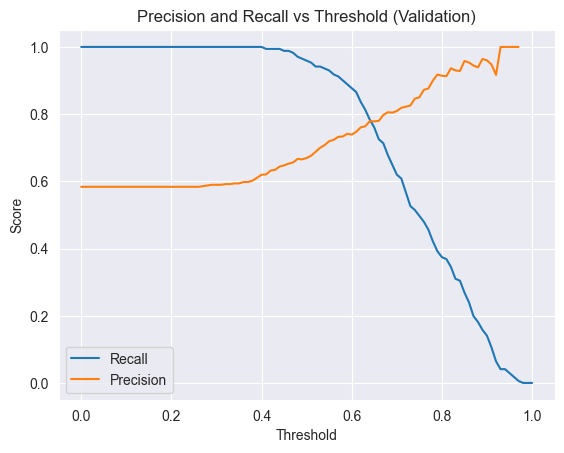

In [122]:
plt.plot(df_scr['threshold'], df_scr['recall'], label='Recall')
plt.plot(df_scr['threshold'], df_scr['precision'], label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold (Validation)')
plt.legend();

## 7. F1 score

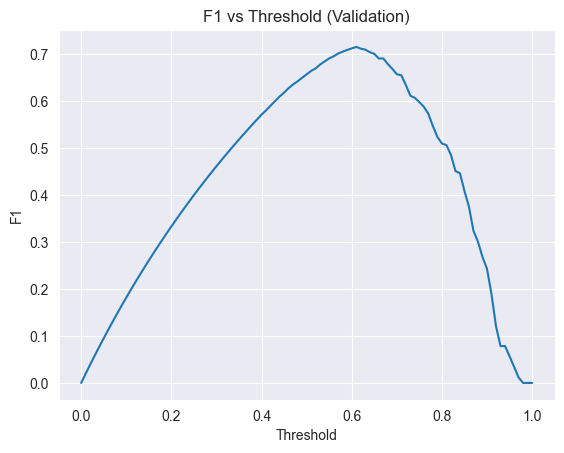

Best F1 threshold: 0.61
Maximal F1: 0.72


In [131]:
# Helper to compute F1 score for different thresholds
def f1_from_pr(p, r):
    if p + r == 0:
        return 0.0
    return 2 * p * r / (p + r)

precisions = df_scr['threshold'].values
recalls = df_scr['recall'].values

f1s = [f1_from_pr(p, r) for p, r in zip(precisions, recalls)]
best_f1_idx = int(np.argmax(f1s))
best_f1_threshold = float(thresholds[best_f1_idx])
best_f1 = float(f1s[best_f1_idx])

# Plot F1 vs threshold
plt.figure()
plt.plot(thresholds, f1s)
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.title('F1 vs Threshold (Validation)')
plt.show()

print(f"Best F1 threshold: {best_f1_threshold}")
print(f"Maximal F1: {best_f1:.2f}")